# Video Games Sales Prediction 

**Done by: Eng. Raneem Ahmed Refaat**

📌**Project Overview**

This project aims to analyze and predict global video game sales using machine learning models. By exploring historical data on game performance, platform trends, genre popularity, and publisher impact, we aim to identify key factors that influence global sales volume. This project involves:

- Data preprocessing and handling missing values

- Encoding categorical features like Platform, Genre, and Publisher

- Feature analysis

- Training regression models to predict Global_Sales

- Evaluating model performance and interpreting results

This analysis helps uncover insights into what makes a video game successful in terms of worldwide sales.

📂 **Dataset Description**

- Source: Kaggle / Public Dataset on Video Game Sales
- Rows: ~16,500
- Columns: 11
- Target Variable: Global_Sales (in millions)

- **Feature Description** 
  - **Rank**: Sales rank of the game  
  - **Name**: Name of the video game  
  - **Platform**: Gaming platform (e.g., PS4, Xbox, PC, etc.)  
  - **Year**: Year of release  
  - **Genre**: Genre category (e.g., Action, Sports, RPG)  
  - **Publisher**: Company that published the game  
  - **NA_Sales**: Sales in North America (in millions)  
  - **EU_Sales**: Sales in Europe (in millions)  
  - **JP_Sales**: Sales in Japan (in millions)  
  - **Other_Sales**: Sales in other regions (in millions)  
  - **Global_Sales**: Total worldwide sales (target variable)

- **Models I'll Use:**
  - Linear Regression 
  - Decision Tree
  - Random Forest
  - Support Vector Machine (SVR)
  - XGBoost

Imported all the essential libraries required for the project for data handling, data visualizing, data preprocessing, model building , model evaluation and saving/loading models

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import os
import joblib


To keep the notebook modular and clean, we define everything to be a function

Starting from **load_data** function that loads dataset from csv file.
- It takes the csv file as path 
- Reads csv and load it into pandas dataframe
- Return the dataframe to be used in notebook 

In [2]:
def load_data(path):
    df = pd.read_csv(path)
    return df

Next we use the load_data function to **load data** from the csv file and **.head()** to view the first 5 rows in data. 

This step is essential for initial exploration. It helps confirm that the data was loaded correctly and gives a quick snapshot of values and data types.

In [3]:
df = load_data('video_games_sales.csv')
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


**.shape** is used next to give insight on the shape of the data, it return a tuple that contain: (Number of Rows, Number of Columns)


In [4]:
df.shape

(16598, 11)

- The dataset contains 16,598 video games and 11 features.
- The data is large enough dataset to train meaningful machine learning models after preprocessing.

Next **.info()** used to get a summary of the dataset, including:
- Total entries
- Non-null counts
- Data types
- Memory usage

Which helped me realise that: 
- Two columns have missing values:
  - Year: 16,327 non-null 
  - Publisher: 16,540 non-null 
  
- Name, Platform, Genre, Publisher are categorical data that needs encoding 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


checked for null (missing) values in each column using **.isnull()** and we sum the number of nulls using **.sum()**, reaching that 271 are missing in year and 58 in Publisher.


In [6]:
df.isnull().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

To prepare our dataset for machine learning, we define a function **preprocess_data(df)** that performs:
- Data cleaning
- Feature engineering
- Encoding of categorical variables
- Feature scaling

1. Rank is dropped as it is an ordering column that will have no effect on ML task

2. I handled missing values: 
  - year is filled with median values, then converted to int
  - Published missing values are filled with 'Unknown' as a placeholder so model can learn from it without losing data by dropping rows.

3. I extracted features from the Name column which represnts the Game Title by Feature Engineering: 
  - **Name_Length**: Length of the title as longer names might affect discoverability 
  - **Word_Count**: Number of words in the title  
  - **Is_Sequel**:  is it likely a sequel? Detects numbers in the title  
  - **First_Word**: First word of the game title (some franchises are very consistent)
  *Then we drop Name since it's no longer needed after extraction.*

4. We apply **One-Hot Encoding** on Platform and Genre since they have many unique values with no ordinal relationship.

5. We use **Label Encoding** for Publisher and First_Word since they can have high cardinality but are less likely to benefit from one-hot (or memory-intensive).

6. define features and target 
  - **X**: All features except the target
  - **y**: Global_Sales (the value we are predicting)

7. Used **Standard Scaler** to standardizes all numeric features. 

8. then returned the cleaned, encoded, and scaled features X_scaled and the target variable y.

This preprocessing ensures:
- The data is clean and numeric  
- Categorical features are handled  
- The dataset is ready for model training



In [7]:
def preprocess_data(df):

    df = df.drop(columns=['Rank'])

    # Fix missing values
    df['Year'] = df['Year'].fillna(df['Year'].median())
    df['Publisher'] = df['Publisher'].fillna('Unknown')
    df['Year'] = df['Year'].astype(int)

 
    # Feature Engineering on Name
    df['Name_Length'] = df['Name'].apply(lambda x: len(str(x)))
    df['Word_Count'] = df['Name'].apply(lambda x: len(str(x).split()))
    df['Is_Sequel'] = df['Name'].apply(lambda x: 1 if re.search(r'\b\d+\b', str(x)) else 0)
    df['First_Word'] = df['Name'].apply(lambda x: str(x).split()[0])

    df = df.drop(columns=['Name'])

     #encode
    onehot_cols = ['Platform', 'Genre']
    df = pd.get_dummies(df, columns=onehot_cols, drop_first=True)

    col = ['Publisher','First_Word']
    le = LabelEncoder()
    for col in col:
     df[col] = le.fit_transform(df[col])

    X = df.drop('Global_Sales', axis=1)
    y = df['Global_Sales']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y


**split_data** function splits the dataset into training and testing sets... it takes :
- **X** : Features
- **y** : Target variable (Global_Sales)
- **test_size=0.2** : 20% of the data will be used for testing, 80% for training
- **random_state=42** : Ensures reproducibility by keeping the same random split every time

In [8]:
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

defined a function **get_models()** that returns a dictionary of pre-configured regression models. 

This structure helps in easily looping through models for training and evaluation.

In [9]:
def get_models():
    models = {
        'Linear Regression': LinearRegression(),

        'Decision Tree': DecisionTreeRegressor(
            max_depth=11,              
            random_state=42
        ),

        'Random Forest': RandomForestRegressor(
            n_estimators=200,
            max_depth=11,                
            random_state=42
        ),

        'Support Vector': SVR(
            kernel='linear'
        ),

        'XGBoost': XGBRegressor(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.3,
            random_state=42
        )
    }

    return models


This function **evaluate_models_with_train_test()** does the following:
- Trains each regression model from **get_models()**
- Predicts values on both training and testing sets
- Calculates evaluation metrics: R² score and RMSE
- Results are saved as a dictionary for each mode
- Returns a sorted DataFrame of results for comparison

- **R² Score:** Coefficient of determination, indicates how well a regression model fits the data
- **RMSE:** Root Mean Squared Error, measures prediction error in the same unit as the target

In [10]:
def evaluate_models_with_train_test(X_train, X_test, y_train, y_test):

    models = get_models()
    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)

        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

        results.append({
            'Model': name,
            'RMSE_Test': round(rmse_test, 3),
            'R2_Train (%)': round(r2_train * 100, 2),
            'R2_Test (%)': round(r2_test * 100, 2)
        })

    return pd.DataFrame(results).sort_values(by='R2_Test (%)', ascending=False)


**display_results** functionis used to print the evaluation summary of all regression models in a clean, tabular format

In [11]:
def display_results(results):
    df_results = pd.DataFrame(results)
    df_results = df_results
    print(df_results)

**save_model** function works once the best-performing model is identified , it is used so we can save it for later reuse or deployment. This function handles that using the **joblib** library

- **model**: The trained machine learning model
- **path**: File path to store the model 

In [12]:
def save_model(model, path):
    joblib.dump(model, path)
    print(f"Model saved Successfully")

**load_model** function help load a previously saved model from a .pkl file using joblib.

In [13]:
def load_model(path):
    if os.path.exists(path):
        return joblib.load(path)
    else:
        raise FileNotFoundError(f"No model found at {path}")

In this final step, we put the entire machine learning pipeline into action

In [14]:
MODEL_PATH = 'VideoGamesSales.pkl'
DATA_PATH = 'video_games_sales.csv'
TEST_SIZE = 0.2
RANDOM_STATE = 42

df = load_data(DATA_PATH) #load data from csv file
X, y = preprocess_data(df) # prepare data for training
X_train, X_test, y_train, y_test = split_data(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE) #split data into training and testing sets
results_df = evaluate_models_with_train_test(X_train, X_test, y_train, y_test) #evaluate models with train and test data
display_results(results_df) #display evaluation metrics of each model

best_model_name = results_df.iloc[0]['Model'] #find the best model based on R² score
print(f"\n best model: {best_model_name}")

# Retrieve and train the best model using the full training set
models = get_models() 
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

save_model(best_model, MODEL_PATH)# Save the trained best model


               Model  RMSE_Test  R2_Train (%)  R2_Test (%)
0  Linear Regression      0.005        100.00       100.00
3     Support Vector      0.047         99.89        99.95
1      Decision Tree      0.782         99.89        85.43
2      Random Forest      0.880         99.61        81.57
4            XGBoost      0.907         99.98        80.41

 best model: Linear Regression
Model saved Successfully


To better understand how each model performed and whether it overfits or generalizes well, i visualize the **R² scores** using side byside bar charts using **plot_r2_train_and_test** function.

In [15]:
def plot_r2_train_and_test(results_df):
    models = results_df['Model']
    r2_train = results_df['R2_Train (%)']
    r2_test = results_df['R2_Test (%)']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

    # Left: Train R²
    ax1.bar(models, r2_train, color='skyblue')
    ax1.set_title('R² Score on Training Set')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('R² (%)')
    ax1.set_ylim(99, 100) #to better show the subtle diffrences 
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.tick_params(axis='x', rotation=45)

    # Right: Test R²
    ax2.bar(models, r2_test, color='lightcoral')
    ax2.set_title('R² Score on Testing Set')
    ax2.set_xlabel('Model')
    ax2.set_ylim(80, 100)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.tick_params(axis='x', rotation=45)

    plt.suptitle('Model R² Comparison (Train vs Test)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


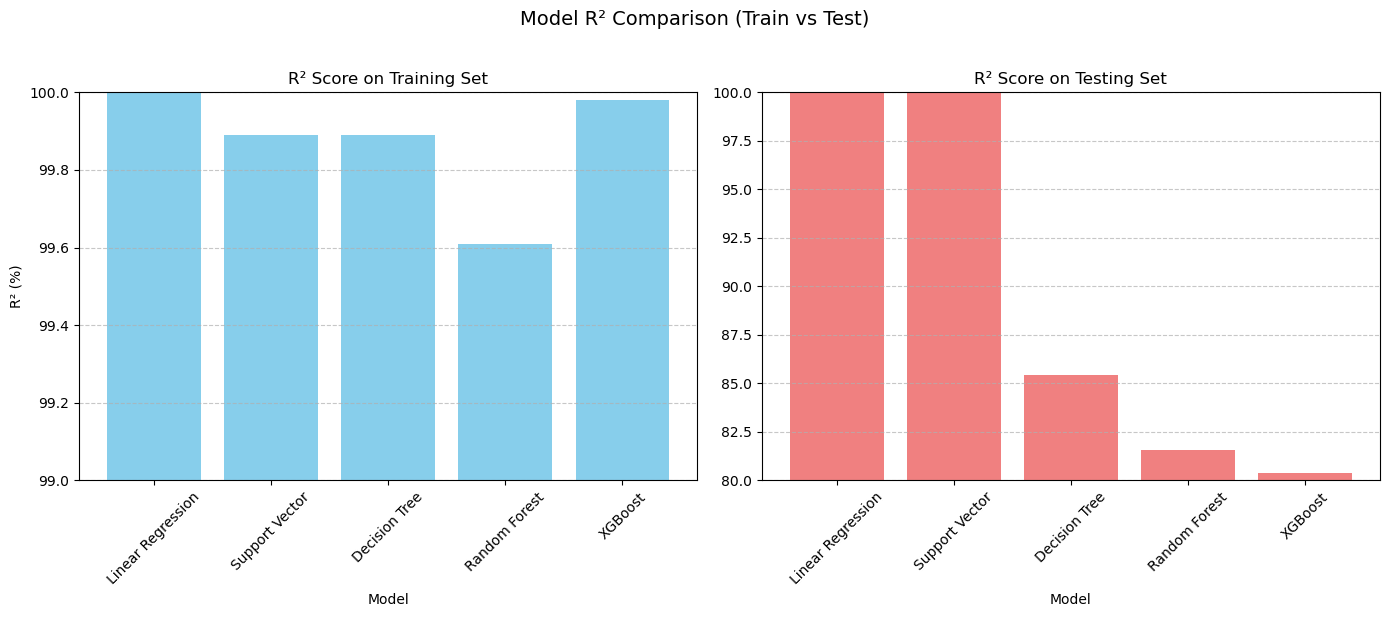

In [16]:
plot_r2_train_and_test(results_df)


**Key Observations:**
- **Linear Regression** performs exceptionally well, achieving ~100% R-squared on both training and testing sets.
 This suggests a strong generalization with minimal overfitting.

- **Support Vector Regressor (SVR)** also shows very high test performance (~99.9%), indicating good predictive capability.

- **Decision Tree, Random Forest, and XGBoost** show:
 - High training R² (nearly 100%), but significantly lower test R² and its a sign of overfitting (the models memorize training data but fail to generalize)


At the end , based on both visual performance and numerical results, **Linear Regression** is the best-performing model for this dataset.


